## Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Web requests and parsing
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup

# Image processing
from PIL import Image
from skimage import io

# Regular expressions and collections
import re
from collections import Counter, defaultdict

# NBA API
import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.library.parameters import SeasonAll, Season, SeasonType
from nba_api.stats.endpoints import (
    playergamelog, 
    teamgamelog, 
    teamdashlineups, 
    leaguelineupviz, 
    leaguegamefinder, 
    commonplayerinfo, 
    shotchartdetail, 
    boxscoreadvancedv3, 
    playbyplay, 
    drafthistory
)
from nba_api.stats.endpoints.synergyplaytypes import LeagueID
from nba_api.stats.endpoints.shotchartlineupdetail import ConferenceNullable

# Visualization
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb

# Pretty printing
import pprint
pp = pprint.PrettyPrinter(indent=4)


## Create dictionaries and helper functions

In [2]:
# Select the dictionary for the Pacers, which contains their team ID
player_dict = players.get_players()
nba_teams = teams.get_teams()
player_info = pd.DataFrame.from_dict(player_dict)
team_info = pd.DataFrame.from_dict(nba_teams)
player_dict = player_info[['id','full_name']].set_index('full_name').to_dict()['id']
team_dict = team_info[['id','abbreviation']].set_index('abbreviation').to_dict()['id']
full_name_dict = team_info.set_index('abbreviation').to_dict()['full_name']
full_name_dict['NOH'] = 'New Orleans Pelicans'

## Lineup Ideas: Find best lineups, determine best lineups for individual players

### Create & Save Lineup DataFrame + Helper Function

In [11]:
def reorder_lineup(x):
    return '-'.join(sorted([a for a in x.split('-') if a.strip()]))

url = "https://api.pbpstats.com/get-lineup-player-stats/nba"
lineup_size = 5


In [ ]:
seasons = ['2012-13','2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2021-22','2022-23','2023-24']
season_type = 'Regular Season'
all_lineups_list = []
team = 'GSW'
team_id = team_dict[team]
minimum_mins_played = 1000
season = '2022-23'


for season in seasons:
   print(season)
   warriors_lineup_df = teamdashlineups.TeamDashLineups(team_id=team_id,group_quantity=lineup_size,season=season,
                                                        season_type_all_star=season_type)\
            .get_data_frames()[1][['GROUP_SET', 'GROUP_ID', 'GROUP_NAME', 'MIN',
         'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK']]
   lineups = list(set(warriors_lineup_df['GROUP_ID']))
   print(lineups)
   for lineup in lineups:
      params = {
         "LineupId": reorder_lineup(lineup), # lineup ids are hyphen separated player ids sorted as strings
         "Season": season,
         "SeasonType": season_type,
         "Minutes":minimum_mins_played
      }
      response = requests.get(url, params=params)
      print(params)
      print(response)
      
      response_json = response.json()
      lineup_stats = response_json['single_row_table_data']
      if 'FG3M' not in lineup_stats.keys():
         lineup_stats['FG3M'] = 0
      if 'FG2M' not in lineup_stats.keys():
         lineup_stats['FG2M'] = 0
      if 'FG3A' not in lineup_stats.keys():
         lineup_stats['FG3A'] = 0
         lineup_stats['FG3M'] = 0
      if 'FG2A' not in lineup_stats.keys():
         lineup_stats['FG2M'] = 0
         lineup_stats['FG2A'] = 0
      if 'FTA' not in lineup_stats.keys():
         lineup_stats['FTA'] = 0
         lineup_stats['FTM'] = 0
      if 'FTM' not in lineup_stats.keys():
         lineup_stats['FTM'] = 0
      if 'OpponentPoints' not in lineup_stats.keys():
         lineup_stats['OpponentPoints'] = 0
      if 'Points' not in lineup_stats.keys():
         lineup_stats['Points'] = 0
         lineup_stats['TsPct'] = 0.0
      if 'TsPct' not in lineup_stats.keys():
         lineup_stats['TsPct'] = 0.0
      if 'ShortName' not in lineup_stats.keys():
          continue
      elif 'Minutes' not in lineup_stats.keys():
          continue
      elif 'DefPoss' not in lineup_stats.keys():
          continue
      elif 'OffPoss' not in lineup_stats.keys():
          continue
      elif 'Minutes' in lineup_stats.keys() and lineup_stats['Minutes'] < minimum_mins_played:
          continue
      else:
         lineup_df = pd.DataFrame([lineup_stats])[["Name", 'OffPoss', 'DefPoss', "Minutes", 'Points', 'OpponentPoints', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'TsPct','FTA']]
         lineup_df = lineup_df.rename(columns={'Name':'Lineup','Points':'Team Points','FG2M': 'Team FG2M', 'FG2A':'Team FG2A', 'FG3M':'Team FG3M', 'FG3A':'Team FG3A', 'TsPct':'Team TsPct','FTA':'Team FTA'})
         lineup_df['Season'] = season
         lineup_df['Team'] = team
         player_stats = response_json['multi_row_table_data']
         for player_stat in player_stats:
            if not set(['Points','TsPct']).issubset(player_stat.keys()):
                  player_stat['Points'] = 0
                  player_stat['TsPct'] = 0.0
            if 'FG3A' not in player_stat.keys():
               player_stat['FG3A'] = 0
               player_stat['FG3M'] = 0
            if 'FG2A' not in player_stat.keys():
               player_stat['FG2M'] = 0
               player_stat['FG2A'] = 0
            if 'FTA' not in player_stat.keys():
               player_stat['FTA'] = 0
            if 'OpponentPoints' not in player_stat.keys():
                  player_stat['OpponentPoints'] = 0
            if 'Minutes' not in player_stat.keys():
               player_stat['Minutes'] = 0
            if 'OffPoss' not in player_stat.keys():
                  player_stat['OffPoss'] = 0
            if 'DefPoss' not in player_stat.keys():
                  player_stat['DefPoss'] = 0
            player_df = pd.DataFrame([player_stat])[['Name', 'EntityId', 'Minutes', 'OffPoss', 'DefPoss', 'Points', 'OpponentPoints', 'TsPct','FG2A','FG3A','FTA']]
            all_lineups_list.append(player_df.merge(lineup_df,on=['Minutes','OffPoss','DefPoss','OpponentPoints']))

In [9]:
all_lineups_df = pd.concat(all_lineups_list).reset_index(drop=True)
all_lineups_df['PtsPer75'] = all_lineups_df['Points'] * 75 / all_lineups_df['OffPoss']
all_lineups_df['FGA'] = all_lineups_df['FG2A'] + all_lineups_df['FG3A']
all_lineups_df['Team FGA'] = all_lineups_df['Team FG2A'] + all_lineups_df['Team FG3A']
all_lineups_df.to_csv(f'{team} Lineup Data ({season_type}).csv')

### Initialize Players + Team

In [10]:
team = 'UTA'
key_player = 'Donovan Mitchell'
star_player = 'Rudy Gobert'
role_player = 'Michael Porter Jr.'
all_lineups_df_reg_season = pd.read_csv(f'{team} Lineup Data (Regular Season).csv')
all_lineups_df_reg_season['Season Type'] = 'Regular Season'
all_lineups_df_playoffs = pd.read_csv(f'{team} Lineup Data (Playoffs).csv')
all_lineups_df_playoffs['Season Type'] = 'Playoffs'



### Track Player Production in Same Lineup across multiple years

In [9]:
all_lineups_df_comb = all_lineups_df_reg_season[all_lineups_df_reg_season['Name']==key_player][['Lineup','OffPoss','Minutes','Points','FGA','FTA']].groupby('Lineup').sum().reset_index().sort_values(by='Minutes')
all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)
all_lineups_df_comb[role_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if role_player in x else 0)
no_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[role_player] == 0)][['Lineup','OffPoss','Minutes','Points','FGA','FTA']]
two_legends_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 1)&(all_lineups_df_comb[role_player] == 0)][['Lineup','OffPoss','Minutes','Points','FGA','FTA']]
two_shooters_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[role_player] == 1)][['Lineup','OffPoss','Minutes','Points','FGA','FTA']]
everyone_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 1)&(all_lineups_df_comb[role_player] == 1)][['Lineup','OffPoss','Minutes','Points','FGA','FTA']]
ns_mins = np.sum(no_stars_df)['Minutes']
jk_mins = np.sum(two_shooters_df)['Minutes']
js_mins = np.sum(two_legends_df['Minutes'])
e_mins = np.sum(everyone_df['Minutes'])

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [10]:

print(f'Points Per 75 without {role_player} or {star_player} ({ns_mins} Minutes Played):')
print(round(np.sum(no_stars_df)['Points'] * 75/ np.sum(no_stars_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(no_stars_df)['Points'] * 100 / (2 * (np.sum(no_stars_df)['FGA'] + 0.44 * np.sum(no_stars_df)['FTA'])),2))
print('\n')
print(f'Points Per 75 with just {role_player} ({jk_mins} Minutes Played):')
print(round(np.sum(two_shooters_df)['Points'] * 75/ np.sum(two_shooters_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(two_shooters_df)['Points'] * 100 / (2 * (np.sum(two_shooters_df)['FGA'] + 0.44 * np.sum(two_shooters_df)['FTA'])),2))
print('\n')
print(f'Points Per 75 with just {star_player} ({js_mins} Minutes Played):')
print(round(np.sum(two_legends_df)['Points'] * 75/ np.sum(two_legends_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(two_legends_df)['Points'] * 100 / (2 * (np.sum(two_legends_df)['FGA'] + 0.44 * np.sum(two_legends_df)['FTA'])),2))
print('\n')
print(f'Points Per 75 with everyone ({e_mins} Minutes Played):')
print(round(np.sum(everyone_df)['Points'] * 75/ np.sum(everyone_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(everyone_df)['Points'] * 100 / (2 * (np.sum(everyone_df)['FGA'] + 0.44 * np.sum(everyone_df)['FTA'])), 2))
print('\n')

Points Per 75 without Michael Porter Jr. or Anthony Davis (3222 Minutes Played):
30.95
TS%:
61.26


Points Per 75 with just Michael Porter Jr. (0 Minutes Played):
nan
TS%:
nan


Points Per 75 with just Anthony Davis (4512 Minutes Played):
24.54
TS%:
58.62


Points Per 75 with everyone (0 Minutes Played):
nan
TS%:
nan




C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-

### Player Production Lineups for the Same Year

In [11]:
all_lineups_df_comb = all_lineups_df_playoffs[['Lineup','OffPoss','DefPoss','Minutes','Points','Team Points','OpponentPoints','FGA','FTA','Season','Name']]
all_lineups_df_comb[key_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if key_player in x else 0)
all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)

no_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[key_player] == 0)][['OffPoss','Minutes','Points','FGA','FTA','Season']].groupby('Season').sum().reset_index()
no_stars_df['PtsPer75'] = round(no_stars_df['Points'] * 75/ no_stars_df['OffPoss'],2)
no_stars_df['TS%'] = round(no_stars_df['Points'] * 100 / (2 * no_stars_df['FGA'] + 0.44 * no_stars_df['FTA']),2)
no_stars_df['Designation'] = 'No Key Players'

one_star_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 1)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name']].groupby(['Season','Name']).sum().reset_index()
one_star_df = one_star_df[one_star_df['Name'].isin([star_player,key_player])]
one_star_df['PtsPer75'] = round(one_star_df['Points'] * 75/ one_star_df['OffPoss'],2)
one_star_df['TS%'] = round(one_star_df['Points'] * 100 / (2 * one_star_df['FGA'] + 0.44 * one_star_df['FTA']),2)
one_star_df['Designation'] = 'One Star Player ' +  '(' + one_star_df['Name'].apply(lambda x: x.split()[-1]) + ')'

two_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 2)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name']].groupby(['Season','Name']).sum().reset_index()
two_stars_df = two_stars_df[two_stars_df['Name'].isin([star_player,key_player])]
two_stars_df['PtsPer75'] = round(two_stars_df['Points'] * 75/ two_stars_df['OffPoss'],2)
two_stars_df['TS%'] = round(two_stars_df['Points'] * 100 / (2 * two_stars_df['FGA'] + 0.44 * two_stars_df['FTA']),2)
two_stars_df['Designation'] = 'Both Stars ' + '(' + two_stars_df['Name'].apply(lambda x: x.split()[-1]) + ')'


comb_df = pd.concat([no_stars_df,one_star_df,two_stars_df]).reset_index(drop=True)

fig2 = px.line(comb_df, x = 'Season', y = 'PtsPer75',color = 'Designation',title=f'Production of {key_player} in Lineups',
        hover_data={'TS%':True, 'Minutes':True,'Designation':False,'Season':False})
fig2.show()


C:\Users\ynakadi\AppData\Local\Temp\ipykernel_22744\2086704192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lineups_df_comb[key_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if key_player in x else 0)
C:\Users\ynakadi\AppData\Local\Temp\ipykernel_22744\2086704192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)
C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundati

### Reg Season vs Playoffs

In [12]:
all_lineups_df_comb = pd.concat([all_lineups_df_reg_season,all_lineups_df_playoffs])
all_lineups_df_comb = all_lineups_df_comb[['Lineup','OffPoss','DefPoss','Minutes','Points','Team Points','OpponentPoints','FGA','FTA','Season','Name','Season Type']]
all_lineups_df_comb[key_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if key_player in x else 0)
all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)

# no_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[key_player] == 0)][['OffPoss','Minutes','Points','FGA','FTA','Season','Season Type']].groupby(['Season','Season Type']).sum().reset_index()
# no_stars_df['PtsPer75'] = round(no_stars_df['Points'] * 75/ no_stars_df['OffPoss'],2)
# no_stars_df['TS%'] = round(no_stars_df['Points'] * 100 / (2 * no_stars_df['FGA'] + 0.44 * no_stars_df['FTA']),2)
# no_stars_df['Designation'] = 'No Key Players'
# no_stars_df_reg, no_stars_df_post = no_stars_df[no_stars_df['Season Type'] == 'Regular Season'], no_stars_df[no_stars_df['Season Type'] == 'Playoffs']
# no_stars_df_post = no_stars_df_post.rename(columns={'TS%':"Playoffs TS%",'PtsPer75':'Playoffs PtsPer75'})
# no_stars_df_comb = no_stars_df_reg.merge(no_stars_df_post[['Season','Playoffs TS%','Playoffs PtsPer75']],on='Season')
# no_stars_df_comb['TS% Playoffs Difference'] = round(no_stars_df_comb['Playoffs TS%'] - no_stars_df_comb['TS%'],2)
# no_stars_df_comb['PtsPer75 Playoffs Difference'] = (no_stars_df_comb['Playoffs PtsPer75'] - no_stars_df_comb['PtsPer75']).round(2)


one_star_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 1)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name','Season Type']].groupby(['Season','Name','Season Type']).sum().reset_index()
one_star_df = one_star_df[one_star_df['Name'].isin([star_player,key_player])]
one_star_df['PtsPer75'] = round(one_star_df['Points'] * 75/ one_star_df['OffPoss'],2)
one_star_df['TS%'] = round(one_star_df['Points'] * 100 / (2 * one_star_df['FGA'] + 0.44 * one_star_df['FTA']),2)
one_star_df['Designation'] = 'One Star Player ' +  '(' + one_star_df['Name'].apply(lambda x: x.split()[-1]) + ')'
one_star_df_reg, one_star_df_post = one_star_df[one_star_df['Season Type'] == 'Regular Season'], one_star_df[one_star_df['Season Type'] == 'Playoffs']
one_star_df_post = one_star_df_post.rename(columns={'TS%':"Playoffs TS%",'PtsPer75':'Playoffs PtsPer75'})
one_star_df_comb = one_star_df_reg.merge(one_star_df_post[['Season','Name','Playoffs TS%','Playoffs PtsPer75']],on=['Season','Name'])
one_star_df_comb['TS% Playoffs Difference'] = round(one_star_df_comb['Playoffs TS%'] - one_star_df_comb['TS%'],2)
one_star_df_comb['PtsPer75 Playoffs Difference'] = round(one_star_df_comb['Playoffs PtsPer75'] - one_star_df_comb['PtsPer75'],2)

two_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 2)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name','Season Type']].groupby(['Season','Name','Season Type']).sum().reset_index()
two_stars_df = two_stars_df[two_stars_df['Name'].isin([star_player,key_player])]
two_stars_df['PtsPer75'] = round(two_stars_df['Points'] * 75/ two_stars_df['OffPoss'],2)
two_stars_df['TS%'] = round(two_stars_df['Points'] * 100 / (2 * two_stars_df['FGA'] + 0.44 * two_stars_df['FTA']),2)
two_stars_df['Designation'] = 'Both Stars ' + '(' + two_stars_df['Name'].apply(lambda x: x.split()[-1]) + ')'
two_stars_df_reg, two_stars_df_post = two_stars_df[two_stars_df['Season Type'] == 'Regular Season'], two_stars_df[two_stars_df['Season Type'] == 'Playoffs']
two_stars_df_post = two_stars_df_post.rename(columns={'TS%':"Playoffs TS%",'PtsPer75':'Playoffs PtsPer75'})
two_stars_df_comb = two_stars_df_reg.merge(two_stars_df_post[['Season','Name','Playoffs TS%','Playoffs PtsPer75']],on=['Season','Name'])
two_stars_df_comb['TS% Playoffs Difference'] = round(two_stars_df_comb['Playoffs TS%'] - two_stars_df_comb['TS%'],2)
two_stars_df_comb['PtsPer75 Playoffs Difference'] = round(two_stars_df_comb['Playoffs PtsPer75'] - two_stars_df_comb['PtsPer75'],2)



comb_df = pd.concat([one_star_df_comb,two_stars_df_comb]).reset_index(drop=True)

fig2 = px.line(comb_df, x = 'Season', y = 'PtsPer75',color = 'Designation',title=f'Production of Jazz Stars in Lineups (Donovan Mitchell, Rudy Gobert)',
        hover_data={'TS%':True, 'Minutes':True,'Designation':False,'Season':True,'TS% Playoffs Difference':True,'PtsPer75 Playoffs Difference':True})
fig2.show()

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\express\_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [13]:
fig2.write_html("file.html")

NBA Podcast (Wharton Moneyball) Notes 
- Seth Stephens-Davidowitz: Who Makes the NBA?, Everybody Lies
- Idea: normalize for height
    - Each inch doubles your chances of joining the nba (7 footers have a 1/7 chance, general population)
- Idea: MJ is 9th best height-adjusted player
    - Muggsy Boges is #1 all time, Chris Paul is #1 among active players
- Idea: negative relation between height and athletic abilities/certain skills
    - Intuition: you don't have to be as good
- Idea: FT% as proxy for clutch shooting (clutch is <= 5 mins remaining in game)
    - Other shots tend to be low probability
    - Typically players' FT% decreased by 1%
    - Influenced primarily by height
- Is clutchness multidimensional or singular
- Coaching:
    - NBA Coaches make the biggest difference
    - Best ideas are in blogs
        - How good player was before playing for the coach compared to now
        - Also adjust for age
- Fixed effect model on how often player passes ball when driving to basket
- PLayers have incentive to solely score: great coaches get players to be more passive 

## Game by Game Data (Basic Team Stats, ORTG, think of other ideas)

### Create Dataframe (if necessary)

In [90]:
dfs = []
def get_opponent(stri):
  if '@' in stri:
    return stri.replace(' ','').split('@')[1]
  else:
    return stri.replace(' ','').split('.')[1]

def get_location(stri):
  if '@' in stri:
    return 0
  else:
    return 1
start_year = 2012
end_year = 2024
for season in [str(x) + '-' + str(x + 1)[2:] for x in range(start_year,end_year)]:
    print(season)
    east_games = leaguegamefinder.LeagueGameFinder(
                              league_id_nullable=LeagueID.nba,
                              vs_conference_nullable=ConferenceNullable.east,
                              season_nullable=season)

    west_games = leaguegamefinder.LeagueGameFinder(
                              league_id_nullable=LeagueID.nba,
                              vs_conference_nullable=ConferenceNullable.west,
                              season_nullable=season
                              )

    # Eastern Conference
    east_games_dict = east_games.get_normalized_dict()
    east_games = east_games_dict['LeagueGameFinderResults']
    east_games_df = pd.DataFrame.from_dict(east_games)
    east_games_df['Opponent Conference'] = 'East'
    
    # Western Conference
    west_games_dict = west_games.get_normalized_dict()
    west_games = west_games_dict['LeagueGameFinderResults']
    west_games_df = pd.DataFrame.from_dict(west_games)
    west_games_df['Opponent Conference'] = 'West'
    
    # Combine them
    comb_df = pd.concat([east_games_df, west_games_df]).reset_index(drop=True)
    
    # Extract Relevant Data
    comb_df['GAME_DATE'] = pd.to_datetime(comb_df['GAME_DATE'])
    comb_df['GAME_TYPE'] = comb_df['GAME_ID'].apply(lambda x: x[2])
    comb_df['SEASON'] = season
    
    #Filter out preseason, all-star games
    comb_df = comb_df[(comb_df['TEAM_ABBREVIATION'].isin(full_name_dict.keys())) & ((comb_df["GAME_TYPE"] != '1') & (comb_df['GAME_TYPE'] != '3'))]
    comb_df['PTS Allowed'] = comb_df['PTS'] - comb_df['PLUS_MINUS']
    comb_df['Opponent'] = comb_df['MATCHUP'].apply(lambda x: get_opponent(x))
    comb_df['At Home'] = comb_df['MATCHUP'].apply(lambda x: get_location(x))
    dfs.append(comb_df)
game_by_game_df = pd.concat(dfs)
game_by_game_df['Win'] = game_by_game_df['WL'].apply(lambda x: 1 if x == 'W' else 0)

2012-13
2013-14
2014-15
2015-16
2016-17
2017-18
2018-19
2019-20
2020-21
2021-22
2022-23
2023-24


In [91]:
key_cols = ['TEAM_ABBREVIATION', 'GAME_ID','GAME_DATE', 'PTS', 'PTS Allowed', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'Win']
game_by_game_opps_df = game_by_game_df[key_cols]
game_by_game_opps_df = game_by_game_opps_df.add_prefix("Opponent ")
combined_df = game_by_game_df.merge(game_by_game_opps_df,right_on=['Opponent TEAM_ABBREVIATION','Opponent GAME_ID', 'Opponent GAME_DATE'],
                           left_on=['Opponent','GAME_ID','GAME_DATE'])
combined_df = combined_df.drop(['Opponent TEAM_ABBREVIATION', 'Opponent GAME_ID',
       'Opponent GAME_DATE','PLUS_MINUS','TEAM_ID','TEAM_NAME','WL','MIN'],axis=1)

In [92]:
combined_df.to_csv('game_by_game.csv', index=False)

### Import DataFrame

In [2]:
game_by_game_df = pd.read_csv('game_by_game.csv',converters={'GAME_ID': str})

In [56]:
game_by_game_df.columns

Index(['SEASON_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'Opponent Conference', 'GAME_TYPE', 'SEASON', 'PTS Allowed', 'Opponent',
       'At Home', 'Win', 'Opponent PTS', 'Opponent PTS Allowed',
       'Opponent FGM', 'Opponent FGA', 'Opponent FG_PCT', 'Opponent FG3M',
       'Opponent FG3A', 'Opponent FG3_PCT', 'Opponent FTM', 'Opponent FTA',
       'Opponent FT_PCT', 'Opponent OREB', 'Opponent DREB', 'Opponent AST',
       'Opponent STL', 'Opponent BLK', 'Opponent TOV', 'Opponent PF',
       'Opponent Win'],
      dtype='object')

### Add Features (maybe remove)

In [14]:
off_rating_df = game_by_game_df[['SEASON','GAME_DATE','GAME_ID','GAME_TYPE','TEAM_ABBREVIATION','PTS','TOV','FGA','FGM','FTA','OREB','DREB']]

team1_df = off_rating_df.sort_values(by='GAME_ID').reset_index(drop=True).iloc[::2]#[['GAME_ID','TEAM_ABBREVIATION','PTS','TOV','FGA','FGM','FTA','OREB','DREB']]
team2_df = off_rating_df.sort_values(by='GAME_ID').reset_index(drop=True).iloc[1::2]

comb1_df = team1_df.merge(team2_df.rename(columns={'TEAM_ABBREVIATION':'OPP TEAM_ABBREVIATION','PTS':'OPP PTS','TOV':'OPP TOV','FGA':'OPP FGA','FGM':'OPP FGM','FTA':'OPP FTA','OREB':'OPP OREB','DREB':'OPP DREB'}), on = 'GAME_ID')
comb2_df = team2_df.merge(team1_df.rename(columns={'TEAM_ABBREVIATION':'OPP TEAM_ABBREVIATION','PTS':'OPP PTS','TOV':'OPP TOV','FGA':'OPP FGA','FGM':'OPP FGM','FTA':'OPP FTA','OREB':'OPP OREB','DREB':'OPP DREB'}), on = 'GAME_ID')
new_stats_df = pd.concat([comb1_df,comb2_df]).sort_values(by='GAME_ID')
new_stats_df = new_stats_df.drop(['SEASON_y','GAME_DATE_y','GAME_TYPE_y'],axis=1)
new_stats_df = new_stats_df.rename(columns = {'SEASON_x' : 'SEASON', 'GAME_DATE_x' : 'GAME_DATE','GAME_TYPE_x':'GAME_TYPE'})

In [15]:
# Pt 1: (Tm FGA + 0.4 * Tm FTA - 1.07 * (Tm ORB / (Tm ORB + Opp DRB)) * (Tm FGA - Tm FG) + Tm TOV)
# Pt 2: (Opp FGA + 0.4 * Opp FTA - 1.07 * (Opp ORB / (Opp ORB + Tm DRB)) * (Opp FGA - Opp FG) + Opp TOV)
def calc_possessions(row):
    pt1 = (row['FGA'] + 0.4 * row['FTA'] - 1.07 * (row['OREB'] / (row['OREB'] + row['OPP DREB'])) * (row['FGA'] - row['FGM']) + row['TOV'])
    pt2 = (row['OPP FGA'] + 0.4 * row['OPP FTA'] - 1.07 * (row['OPP OREB'] / (row['OPP OREB'] + row['DREB'])) * (row['OPP FGA'] - row['OPP FGM']) + row['OPP TOV'])
    return (pt1 + pt2) * 0.5

def calc_offrating(row):
    pt1 = (row['FGA'] + 0.4 * row['FTA'] - 1.07 * (row['OREB'] / (row['OREB'] + row['OPP DREB'])) * (row['FGA'] - row['FGM']) + row['TOV'])
    pt2 = (row['OPP FGA'] + 0.4 * row['OPP FTA'] - 1.07 * (row['OPP OREB'] / (row['OPP OREB'] + row['DREB'])) * (row['OPP FGA'] - row['OPP FGM']) + row['OPP TOV'])
    return round(row['PTS'] * 200 / (pt1 + pt2),1)

def calc_defrating(row):
    pt1 = (row['FGA'] + 0.4 * row['FTA'] - 1.07 * (row['OREB'] / (row['OREB'] + row['OPP DREB'])) * (row['FGA'] - row['FGM']) + row['TOV'])
    pt2 = (row['OPP FGA'] + 0.4 * row['OPP FTA'] - 1.07 * (row['OPP OREB'] / (row['OPP OREB'] + row['DREB'])) * (row['OPP FGA'] - row['OPP FGM']) + row['OPP TOV'])
    return row['OPP PTS'] * 200 / (pt1 + pt2)

new_stats_df['NUM POSSESSIONS'] = new_stats_df.apply(lambda row: calc_possessions(row), axis = 1)
new_stats_df['OFF RATING'] = 100 * new_stats_df['PTS'] / new_stats_df['NUM POSSESSIONS']
new_stats_df['DEF RATING'] = 100 * new_stats_df['OPP PTS'] / new_stats_df['NUM POSSESSIONS']
new_stats_df['NET RATING'] = new_stats_df['OFF RATING'] - new_stats_df['DEF RATING']

In [17]:
new_stats_df[(new_stats_df['GAME_TYPE']==4)&(new_stats_df['GAME_DATE']<'2025-01-01')&(new_stats_df['TEAM_ABBREVIATION']=='MIN')]

,SEASON,GAME_DATE,GAME_ID,GAME_TYPE,TEAM_ABBREVIATION,PTS,TOV,FGA,FGM,FTA,...,OPP TOV,OPP FGA,OPP FGM,OPP FTA,OPP OREB,OPP DREB,NUM POSSESSIONS,OFF RATING,DEF RATING,NET RATING
13371,2017-18,2018-04-15,0041700141,4,MIN,101,13,80,35,28,...,11,83,39,23,8,29,92.799375,108.836940,112.069720,-3.232780
13372,2017-18,2018-04-18,0041700142,4,MIN,82,16,80,31,21,...,9,96,35,21,12,42,97.153460,84.402553,104.988541,-20.585988
13373,2017-18,2018-04-21,0041700143,4,MIN,121,7,90,45,22,...,10,81,37,25,7,32,94.465500,128.089091,111.151690,16.937400
13374,2017-18,2018-04-23,0041700144,4,MIN,100,16,84,39,23,...,6,92,40,26,10,36,97.770471,102.280371,121.713641,-19.433270
13375,2017-18,2018-04-25,0041700145,4,MIN,104,8,79,40,20,...,4,88,45,19,8,32,89.991625,115.566310,135.568171,-20.001861
13704,2021-22,2022-04-16,0042100151,4,MIN,130,18,90,45,27,...,12,86,39,43,8,27,105.352782,123.394939,111.055445,12.339494
13705,2021-22,2022-04-19,0042100152,4,MIN,96,19,76,30,28,...,9,92,44,32,14,34,100.219074,95.790149,123.728942,-27.938793
13706,2021-22,2022-04-21,0042100153,4,MIN,95,16,85,33,23,...,18,83,35,31,13,35,98.690879,96.260162,105.379546,-9.119384
13707,2021-22,2022-04-23,0042100154,4,MIN,119,15,74,35,40,...,17,86,42,25,6,33,101.635882,117.084633,116.100729,0.983904
13708,2021-22,2022-04-26,0042100155,4,MIN,109,22,83,37,24,...,16,94,39,39,18,35,106.690203,102.164957,104.039543,-1.874586


In [18]:
new_stats_reg_df = new_stats_df[new_stats_df['GAME_TYPE'] == 2][['SEASON','TEAM_ABBREVIATION','PTS','OPP PTS','NUM POSSESSIONS']]
new_stats_reg_df['TEAM'] = new_stats_reg_df['TEAM_ABBREVIATION'] + ' ' + new_stats_reg_df['SEASON']
season_stats_df = new_stats_reg_df[['TEAM','PTS','OPP PTS','NUM POSSESSIONS']].groupby('TEAM').sum()
season_stats_df['OFF RATING'] = round(100 * season_stats_df['PTS'] / season_stats_df['NUM POSSESSIONS'],1)
season_stats_df['DEF RATING'] = round(100 * season_stats_df['OPP PTS'] / season_stats_df['NUM POSSESSIONS'],1)
season_stats_df['NET RATING'] = season_stats_df['OFF RATING'] - season_stats_df['DEF RATING']
season_stats_df.sort_values(by='OFF RATING').tail(20)

,PTS,OPP PTS,NUM POSSESSIONS,OFF RATING,DEF RATING,NET RATING
TEAM,,,,,,
DEN 2022-23,9495,9222,8024.116694,118.3,114.9,3.4
POR 2020-21,8360,8231,7068.430953,118.3,116.4,1.9
LAC 2020-21,8209,7764,6934.288319,118.4,112.0,6.4
UTA 2020-21,8382,7716,7081.034552,118.4,109.0,9.4
GSW 2023-24,8063,7941,6794.982815,118.7,116.9,1.8
ATL 2023-24,8095,8232,6822.229274,118.7,120.7,-2.0
NOP 2023-24,7886,7528,6637.716895,118.8,113.4,5.4
PHX 2023-24,8067,7893,6791.678227,118.8,116.2,2.6
BOS 2022-23,9671,9136,8141.908019,118.8,112.2,6.6


In [19]:
new_stats_reg_df = new_stats_df[new_stats_df['GAME_TYPE'] == 4][['SEASON','TEAM_ABBREVIATION','OFF RATING','DEF RATING','NET RATING']]
new_stats_reg_df['TEAM'] = new_stats_reg_df['TEAM_ABBREVIATION'] + ' ' + new_stats_reg_df['SEASON']
season_stats_df = new_stats_reg_df[['TEAM','OFF RATING','DEF RATING','NET RATING']].groupby('TEAM').mean().round(1)

season_stats_df.sort_values(by = 'OFF RATING',ascending=False).head(20)

,OFF RATING,DEF RATING,NET RATING
TEAM,,,
UTA 2019-20,123.4,119.2,4.2
UTA 2020-21,122.6,123.9,-1.3
POR 2020-21,122.2,123.2,-1.0
LAC 2020-21,121.6,117.2,4.4
CLE 2016-17,120.9,112.5,8.4
DEN 2022-23,120.3,111.5,8.8
GSW 2016-17,119.3,106.0,13.4
NOP 2021-22,118.5,120.1,-1.6
BOS 2022-23,118.2,114.6,3.6


In [20]:
# Regular Season Games
reg_games = game_by_game_df[game_by_game_df['GAME_TYPE'] == 2]
game_by_game_df['Team'] = game_by_game_df['TEAM_ABBREVIATION'] + ' ' + game_by_game_df['SEASON']

wins = game_by_game_df[['TEAM_ABBREVIATION','Win','SEASON','GAME_TYPE']].groupby(by=['TEAM_ABBREVIATION','SEASON','GAME_TYPE']).count().reset_index()

# Playoff Games
playoff_teams = game_by_game_df[game_by_game_df['GAME_TYPE'] >= 4]['Team']
post_games = game_by_game_df[game_by_game_df['GAME_TYPE'] >= 4]

graph_df = post_games[['TEAM_ABBREVIATION','PLUS_MINUS','SEASON','Win']].groupby(by=['TEAM_ABBREVIATION','SEASON']).agg(Wins=('Win', np.sum),Plus_Minus =('PLUS_MINUS', np.mean)).reset_index()
graph_df['Team'] = graph_df['TEAM_ABBREVIATION'] + ' ' + graph_df['SEASON']
graph_df = graph_df.sort_values(by='Wins',ascending=True)

fig = px.scatter(graph_df[graph_df['Team'].isin(playoff_teams)], x = 'Wins', y = 'Plus_Minus', color = 'TEAM_ABBREVIATION', text="Team")
fig.update_traces(textposition='top center')
fig.show()

graph2_df = post_games[['TEAM_ABBREVIATION','PTS','SEASON','PTS Allowed']].groupby(by=['TEAM_ABBREVIATION','SEASON']).mean().reset_index()
graph2_df['Team'] = graph2_df['TEAM_ABBREVIATION'] + ' ' + graph2_df['SEASON']
fig2 = px.scatter(graph2_df[graph2_df['Team'].isin(playoff_teams)], x = 'PTS', y = 'PTS Allowed', color = 'TEAM_ABBREVIATION', text="Team")
fig2.update_traces(textposition='top center')
fig2['layout']['yaxis']['autorange'] = "reversed"
fig2.show()


C:\Users\ynakadi\AppData\Local\Temp\ipykernel_23284\2916166130.py:11: FutureWarning: The provided callable <function sum at 0x000001DF9E8AC5E0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  graph_df = post_games[['TEAM_ABBREVIATION','PLUS_MINUS','SEASON','Win']].groupby(by=['TEAM_ABBREVIATION','SEASON']).agg(Wins=('Win', np.sum),Plus_Minus =('PLUS_MINUS', np.mean)).reset_index()
C:\Users\ynakadi\AppData\Local\Temp\ipykernel_23284\2916166130.py:11: FutureWarning: The provided callable <function mean at 0x000001DF9E8AD510> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  graph_df = post_games[['TEAM_ABBREVIATION','PLUS_MINUS','SEASON','Win']].groupby(by=['TEAM_ABBREVIATION','SEASON']).agg(Wins=('Win', np.sum),Plus_Minus =('PLUS_MINUS', np.me

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\express\_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Home Court Advantage?

C:\Users\ynakadi\AppData\Local\Temp\ipykernel_32836\1846838543.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df['Cum Wins'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON']).apply(lambda x:
C:\Users\ynakadi\AppData\Local\Temp\ipykernel_32836\1846838543.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lines_df['Home Win%'] = ~(lines_df['At Home'] ^ lines_df['Win']) + 2


<AxesSubplot: xlabel='SEASON', ylabel='value'>

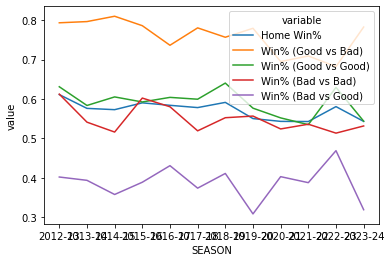

In [41]:
test_df = game_by_game_df[game_by_game_df['SEASON_ID'] - 40000 < 0].sort_values(by=['TEAM_ABBREVIATION','GAME_DATE']).reset_index(drop=True)

test_df = test_df[['GAME_ID','TEAM_ABBREVIATION','SEASON','At Home','Win','Opponent']]
test_df['Cum Wins'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON']).apply(lambda x:
    x.Win.cumsum().shift(1)).reset_index(drop=True)
test_df = test_df.fillna(0)
test_df['Games so Far'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON']).cumcount()
test_df['Win Percentage'] = test_df['Cum Wins'] / test_df['Games so Far']

test_df_opp = test_df
test_df_opp = test_df_opp.add_prefix("Opponent ")
full_df = test_df.merge(test_df_opp,right_on=['Opponent TEAM_ABBREVIATION','Opponent GAME_ID'],
                           left_on=['Opponent','GAME_ID'])

full_df = full_df.dropna()
full_df['Opponent > 0.500'] = full_df['Opponent Win Percentage'].apply(lambda x: 1 if x >= 0.5 else 0)
full_df['> 0.500'] = full_df['Win Percentage'].apply(lambda x: 1 if x >= 0.5 else 0)
# full_df['Home Win'] = ~(full_df['At Home'] ^ full_df['Win']) + 2

lines_df = full_df[['SEASON','GAME_ID','At Home', 'Win','Opponent > 0.500','> 0.500']]
good_vs_good = lines_df[(lines_df['> 0.500'] == 1) & (lines_df['At Home'] == 1) &
                        (lines_df['Opponent > 0.500'] == 1)][['SEASON','Win']].groupby('SEASON').mean()
good_vs_bad = lines_df[(lines_df['> 0.500'] == 1) & (lines_df['At Home'] == 1) &
                        (lines_df['Opponent > 0.500'] == 0)][['SEASON','Win']].groupby('SEASON').mean()
bad_vs_good = lines_df[(lines_df['> 0.500'] == 0) & (lines_df['At Home'] == 1) &
                        (lines_df['Opponent > 0.500'] == 1)][['SEASON','Win']].groupby('SEASON').mean()
bad_vs_bad = lines_df[(lines_df['> 0.500'] == 0) & (lines_df['At Home'] == 1) &
                        (lines_df['Opponent > 0.500'] == 0)][['SEASON','Win']].groupby('SEASON').mean()
lines_df['Home Win%'] = ~(lines_df['At Home'] ^ lines_df['Win']) + 2
avg = lines_df[['SEASON','Home Win%']].groupby('SEASON').mean()
merge1 = pd.merge(good_vs_bad,good_vs_good,on='SEASON',suffixes=("% (Good vs Bad)","% (Good vs Good)"))
merge2 = pd.merge(bad_vs_bad,bad_vs_good,on='SEASON',suffixes=("% (Bad vs Bad)","% (Bad vs Good)"))
lines_df = avg.merge(merge1.merge(merge2,on='SEASON'),on='SEASON').melt(ignore_index=False)

sns.lineplot(lines_df,x='SEASON',y='value',hue='variable')

## Shot Chart Detail Ideas

In [4]:


bucks_df = game_by_game_df[(game_by_game_df['TEAM_ABBREVIATION'] == 'MIL')&(game_by_game_df['SEASON']=='2022-23')]

#player_details = [player for player in player_dict if player['full_name'] == 'Giannis Antetokounmpo'][0]


player_num = player_dict['Giannis Antetokounmpo']
print(player_num)

player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_num)
player_stats = player_info.player_headline_stats.get_dict()
print(player_stats)


pd.options.display.max_seq_items = 100
shot_chart = shotchartdetail.ShotChartDetail(
player_id = 0,
season_nullable='2021-22',
season_type_all_star='Regular Season',
team_id=team_dict['MIL'],
context_measure_simple='FGA',)


shot_df = shot_chart.shot_chart_detail.get_data_frame()
shot_df['Opponent'] = shot_df['HTM'].apply(lambda x: x if x != 'MIL' else '') + shot_df['VTM'].apply(lambda x: x if x != 'MIL' else '')
shot_df['Shot'] = shot_df['SHOT_ZONE_AREA'] + ' ' + shot_df['SHOT_ZONE_BASIC']
# Columns: 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME', 'PERIOD', 
# 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 
# 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE' 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 
# 'GAME_DATE', 'HTM', 'VTM'
print(set(shot_df['Opponent']))
shot_df[['PLAYER_ID','Opponent','Shot','SHOT_MADE_FLAG']]\
    .groupby(['PLAYER_ID','Opponent','Shot']).agg({'SHOT_MADE_FLAG':['count','mean']})
# # Get specific player shot chart
# player_made_df = shot_df[(shot_df['SHOT_MADE_FLAG']==1) & (shot_df['PLAYER_ID']==player_num)]
# player_missed_df = shot_df[(shot_df['SHOT_MADE_FLAG']==0) & (shot_df['PLAYER_ID']==player_num)]

# # Get rest of team shot chart
# rest_of_team_made_df = shot_df[(shot_df['SHOT_MADE_FLAG']==1) & (shot_df['PLAYER_ID']!=player_num)]
# rest_of_team_missed_df = shot_df[(shot_df['SHOT_MADE_FLAG']==0) & (shot_df['PLAYER_ID']!=player_num)]
# giannis_df = shot_df[(shot_df['PLAYER_ID']==player_num)]

bucks_games = pd.concat([boxscoreadvancedv3.BoxScoreAdvancedV3(game_id = game).get_data_frames()[0] for game in set(bucks_df['GAME_ID'])])
# #bucks_games_pbp = pd.concat([playbyplay.PlayByPlay(game).get_data_frames()[0] for game in set(bucks_df['GAME_ID'])])
# giannis_games = bucks_games[bucks_games['NICKNAME'] == 'Giannis']

203507
{'headers': ['PLAYER_ID', 'PLAYER_NAME', 'TimeFrame', 'PTS', 'AST', 'REB', 'PIE'], 'data': [[203507, 'Giannis Antetokounmpo', '2023-24', 30.4, 6.5, 11.5, 0.197]]}
{'TOR', 'CLE', 'UTA', 'SAS', 'HOU', 'MIA', 'PHI', 'BKN', 'SAC', 'POR', 'MIN', 'DEN', 'PHX', 'LAL', 'NOP', 'ORL', 'OKC', 'LAC', 'GSW', 'DET', 'CHI', 'IND', 'CHA', 'ATL', 'BOS', 'NYK', 'MEM', 'WAS', 'DAL'}


KeyboardInterrupt: 

In [24]:
# bucks_games[['gameId','personId','teamTricode','comment','minutes','offensiveRating', 'defensiveRating', 'netRating',
#               'offensiveReboundPercentage', 'pace','possessions']]

x = game_by_game_df[game_by_game_df['TEAM_ABBREVIATION']=='MIL'].sort_values(by='GAME_DATE')[["TEAM_ID",
'TEAM_ABBREVIATION','GAME_ID','GAME_DATE','PTS','TOV','PF','PTS Allowed','At Home',
'FGA','FG_PCT','FG3A', 'FG3_PCT', 'FTA', 'FT_PCT', 'OREB', 'DREB','AST', 'STL', 'BLK','Opponent','Win']].head(2)

KeyError: "['TEAM_ID'] not in index"

In [74]:
rows = []
incomplete_df = pd.read_csv('All Data CSVS/2021_22alldata.csv', converters={'GAME_ID':str})
mil2012_df = game_by_game_df[(game_by_game_df['SEASON']=='2021-22')].sort_values(by='GAME_DATE')[[
'TEAM_ABBREVIATION','GAME_ID','GAME_DATE','PTS','TOV','PF','At Home',
'FGA','FGM','FG3A', 'FG3M', 'FTA', 'FTM', 'OREB', 'DREB','AST', 'STL', 'BLK','Opponent',
'Opponent PTS', 'Opponent FGM', 'Opponent FGA',
       'Opponent FG_PCT', 'Opponent FG3M', 'Opponent FG3A', 'Opponent FG3_PCT',
       'Opponent FTM', 'Opponent FTA', 'Opponent FT_PCT', 'Opponent OREB',
       'Opponent DREB', 'Opponent AST', 'Opponent STL', 'Opponent BLK',
       'Opponent TOV', 'Opponent PF','SEASON','Opponent Win','Win']]

mil2012_df = mil2012_df[~mil2012_df['GAME_ID'].isin(incomplete_df['GAME_ID'])]
print(len(mil2012_df))

count = 0
for a, row in mil2012_df.iterrows():
    count += 1
    if count % 10 == 0:
        print(count)
    boxscore_df = boxscoreadvancedv3.BoxScoreAdvancedV3(game_id = row.GAME_ID).get_data_frames()[1]
    boxscore_df = boxscore_df[['gameId', 'teamId', 'teamTricode','offensiveRating','defensiveRating','possessions','assistToTurnover','offensiveReboundPercentage', 'defensiveReboundPercentage']]
    boxscore_team = boxscore_df[boxscore_df['teamTricode'] == row.TEAM_ABBREVIATION]
    boxscore_opponent = boxscore_df[boxscore_df['teamTricode'] != row.TEAM_ABBREVIATION]
    boxscore_opponent = boxscore_opponent.add_prefix("Opponent ")
    row = pd.DataFrame(row).transpose()
    row = row.merge(boxscore_team,left_on=['GAME_ID','TEAM_ABBREVIATION'],right_on=['gameId','teamTricode'])
    row = row.merge(boxscore_opponent,left_on=['GAME_ID'],right_on=['Opponent gameId'])
    rows.append(row)

1494
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490


In [75]:
full_df = pd.concat(rows)
full_df = full_df.drop(['gameId', 'teamId', 'teamTricode','Opponent gameId', 'Opponent teamId'],axis = 1)
full_df = pd.concat([incomplete_df, full_df])

In [77]:
full_df.reset_index()

,index,Unnamed: 0.1,Unnamed: 0,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,PTS,TOV,PF,At Home,...,assistToTurnover,offensiveReboundPercentage,defensiveReboundPercentage,Opponent teamTricode,Opponent offensiveRating,Opponent defensiveRating,Opponent possessions,Opponent assistToTurnover,Opponent offensiveReboundPercentage,Opponent defensiveReboundPercentage
0,0,0.0,0.0,LAL,0022100002,2021-10-19,114,17,25,1,...,1.17,0.189,0.759,GSW,107.1,101.8,113.0,1.76,0.241,0.811
1,1,1.0,0.0,GSW,0022100002,2021-10-19,121,17,18,0,...,1.76,0.241,0.811,LAL,101.8,107.1,112.0,1.17,0.189,0.759
2,2,2.0,0.0,MIL,0022100001,2021-10-19,127,7,19,1,...,3.13,0.293,0.824,BKN,102.0,124.5,102.0,1.46,0.176,0.707
3,3,3.0,0.0,BKN,0022100001,2021-10-19,104,12,17,0,...,1.46,0.176,0.707,MIL,124.5,102.0,102.0,3.13,0.293,0.824
4,4,4.0,0.0,DEN,0022100012,2021-10-20,110,17,20,0,...,1.32,0.171,0.741,PHX,97.0,108.9,101.0,1.28,0.259,0.829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,0,NaN,NaN,GSW,0042100404,2022-06-10,107,16,21,0,...,1.25,0.385,0.736,BOS,101.0,111.5,96.0,1.38,0.264,0.615
2630,0,NaN,NaN,GSW,0042100405,2022-06-13,104,6,28,1,...,3.29,0.106,0.750,BOS,95.9,107.2,98.0,1.00,0.250,0.894
2631,0,NaN,NaN,BOS,0042100405,2022-06-13,94,18,16,0,...,1.00,0.250,0.894,GSW,107.2,95.9,97.0,3.29,0.106,0.750
2632,0,NaN,NaN,BOS,0042100406,2022-06-16,90,22,16,1,...,1.17,0.348,0.593,GSW,109.6,96.8,94.0,1.59,0.407,0.652


In [78]:
full_df.to_csv('All Data CSVs/2021_22alldata.csv')

In [63]:
# Full data for: 2012_13, 2013-14, 2014-15, 2015-16, 2016-17, 2019-20, 2020-21, 2022-23, 2023-24
full_df = pd.read_csv('All Data CSVs/2017_18alldata.csv')
len(full_df)


721

In [86]:
start_year = 2012
end_year = 2024
all_data_dfs = []
for season in [str(x) + '_' + str(x + 1)[2:] for x in range(start_year,end_year)]:
    all_data_dfs.append(pd.read_csv(f'All Data CSVs/{season}alldata.csv',converters={'GAME_ID':str}))

In [87]:
all_data_df = pd.concat(all_data_dfs)

In [106]:
key_cols = ['TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'PTS', 'TOV',
       'PF', 'At Home', 'FGA', 'FGM', 'FG3A', 'FG3M', 'FTA', 'FTM', 'OREB',
       'DREB', 'AST', 'STL', 'BLK', 'Opponent', 'Opponent PTS', 'Opponent FGM',
       'Opponent FGA', 'Opponent FG_PCT', 'Opponent FG3M', 'Opponent FG3A',
       'Opponent FG3_PCT', 'Opponent FTM', 'Opponent FTA', 'Opponent FT_PCT',
       'Opponent OREB', 'Opponent DREB', 'Opponent AST', 'Opponent STL',
       'Opponent BLK', 'Opponent TOV', 'Opponent PF', 'SEASON', 'Win',
       'offensiveRating', 'defensiveRating', 'possessions', 'assistToTurnover',
       'offensiveReboundPercentage', 'defensiveReboundPercentage',
       'Opponent offensiveRating',
       'Opponent defensiveRating', 'Opponent possessions',
       'Opponent assistToTurnover', 'Opponent offensiveReboundPercentage',
       'Opponent defensiveReboundPercentage', 'Opponent Win']
all_data_df = all_data_df[key_cols]

In [107]:
all_data_df.to_csv("All Data CSVs/AllData.csv")

## PBP Data (Lead Volatility Idea)

### Create PBP Dataset

In [53]:
game_season_dict = game_by_game_df[['SEASON','GAME_ID']].set_index('GAME_ID').to_dict()['SEASON']
game_season_dict
# games = sorted(list(set(game_by_game_df['GAME_ID'])))
main_df = []
num_so_far = 12552
shuffle = 1500
count = 0
pbp_df = pd.read_csv('pbp_df.csv', converters={'GAME_ID':str})
for game in list(set(game_by_game_df['GAME_ID']) - set(pbp_df['GAME_ID'])):
    df = pd.DataFrame()
    temp_df = playbyplay.PlayByPlay(game).get_data_frames()[0]
    count += 1
    if count % 100  == 0:
        print(count)
    temp_df = temp_df[(temp_df['SCOREMARGIN'].notnull())]
    temp_df['SCOREMARGIN'] = temp_df['SCOREMARGIN'].replace("TIE","0").apply(lambda x: int(x))
    main_df.append(temp_df)


# First 12552

100
200


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [42]:
pbp_df = pd.read_csv('pbp_df.csv', converters={'GAME_ID':str})

0          0021300001
1          0021300001
2          0021300001
3          0021300001
4          0021300001
              ...    
1739710    0022301194
1739711    0022301194
1739712    0022301194
1739713    0022301194
1739714    0022301194
Name: GAME_ID, Length: 1739715, dtype: object

In [84]:
# First runthrough
#pbp_df = pd.concat(main_df)
pbp_df = pd.read_csv('pbp_df.csv', converters={'GAME_ID':str})
pbp_df = pd.concat([pbp_df,pd.concat(main_df)])#[['Season','Blown Leads']].groupby('Season').agg({'Blown Leads':['sum','count']})
pbp_df.to_csv('pbp_df.csv', index=False)

In [67]:
pbp_df = pbp_df.drop_duplicates()
pbp_df.to_csv('pbp_df.csv', index=False)

In [85]:
len(set(pbp_df['GAME_ID']))

14142

### Analyze

In [54]:
pbp_df = pd.read_csv('pbp_df.csv', converters={'GAME_ID':str})

#### Lead Volatility

In [79]:
big_lead = 10
small_deficit = 0
#pbp_df = pbp_df.sort_values(by=['GAME_ID','EVENTNUM']).reset_index(drop=True)
pbp_filtered = pbp_df.loc[(np.abs(pbp_df.SCOREMARGIN) <= small_deficit) |
                      (np.abs(pbp_df.SCOREMARGIN) >= big_lead)].copy()

pbp_filtered['new_game'] = pbp_filtered['GAME_ID'] != pbp_filtered.shift(1)['GAME_ID']

pbp_filtered['state'] = pbp_filtered.apply(lambda x: 'bl' if np.abs(x.SCOREMARGIN) >= big_lead else \
                                           ('ng' if x.new_game else \
                           ('sl' if np.abs(x.SCOREMARGIN) <= small_deficit else None)),axis=1)

In [80]:
blown_leads_df = pbp_filtered[['SCOREMARGIN','state','GAME_ID','new_game']].dropna().reset_index(drop=True)
blown_leads_df['check'] = blown_leads_df['state'] + blown_leads_df.shift(1)['state'] 

In [81]:
blown_leads_df['Season'] = blown_leads_df['GAME_ID'].apply(lambda x: '20' + str(x[3:5]) + '-' + str(int(x[3:5])+1))
blown_leads_df['Season Type'] = blown_leads_df['GAME_ID'].apply(lambda x: 'Regular Season' if x[2] == '2' else 'Playoffs')
all_leads_df = blown_leads_df[blown_leads_df['check'].isin(['blbl','blsl'])]
blown_leads_df = blown_leads_df[blown_leads_df['check']=='slbl']
blown_leads_agg = blown_leads_df[['Season','Season Type','GAME_ID']].groupby(['Season','Season Type']).count()
all_leads_agg = all_leads_df[['Season','Season Type','GAME_ID']].drop_duplicates().groupby(['Season','Season Type']).count()

<AxesSubplot: xlabel='Season', ylabel='Blown Lead Pct'>

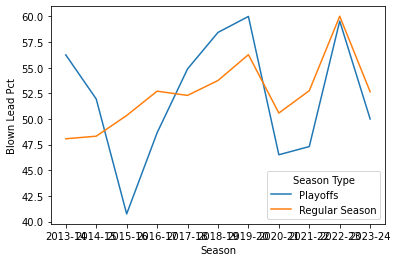

In [82]:
lead_comb_df = all_leads_agg.merge(blown_leads_agg,on=['Season','Season Type'])
lead_comb_df = lead_comb_df.rename(columns={'GAME_ID_x':f'# {big_lead} Pt Leads',
                                            'GAME_ID_y':f'# {big_lead} Pt Blown Leads'})
lead_comb_df['Blown Lead Pct'] = round(100*lead_comb_df[f'# {big_lead} Pt Blown Leads'] / lead_comb_df[f'# {big_lead} Pt Leads'],2)
lead_comb_df
sns.lineplot(lead_comb_df,x='Season',y='Blown Lead Pct',hue='Season Type')

#### End of Games

In [87]:
pbp_df.groupby('GAME_ID')['SCORE'].max()

GAME_ID
0021300001      9 - 17
0021300002    95 - 107
0021300003    99 - 114
0021300004     94 - 98
0021300005     98 - 95
                ...   
0052300121     99 - 99
0052300131    94 - 118
0052300201    91 - 112
0052300211    98 - 105
0062300001    99 - 115
Name: SCORE, Length: 14142, dtype: object

In [88]:
game_by_game_df[game_by_game_df['GAME_ID']=='0062300001']

,SEASON_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,PTS,FGM,FGA,FG_PCT,FG3M,...,Opponent FTA,Opponent FT_PCT,Opponent OREB,Opponent DREB,Opponent AST,Opponent STL,Opponent BLK,Opponent TOV,Opponent PF,Opponent Win
30294,62023,LAL,0062300001,2023-12-09,LAL vs. IND,123,47,88,0.534,2,...,33,0.879,9,23,27,10,7,9,33,0
30295,62023,IND,0062300001,2023-12-09,IND @ LAL,109,35,95,0.368,10,...,35,0.771,12,43,25,5,10,18,25,1


## Data Visualization Ideas

In [ ]:
image_df = pd.read_csv("NBAIMAGES.csv")
image_df["Team"] = image_df['Team'].apply(lambda x: full_name_dict[x])
#image_df

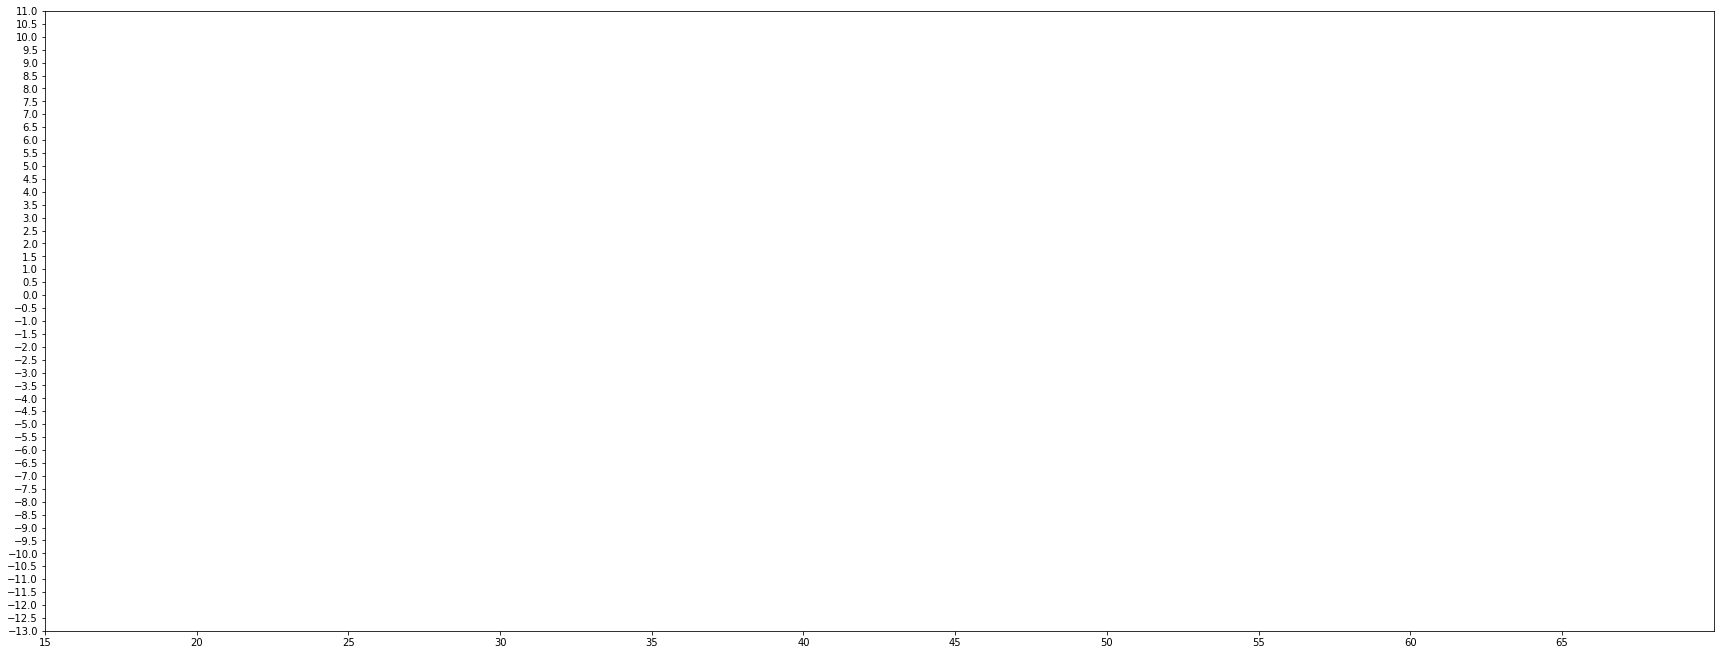

In [ ]:
scale = 0.8
x_shift = -.7 * scale
y_shift = -.8 * scale
image_shift = 500.0
zoom_shift = 0.06 * scale
length = 30.00 * scale
width = 11.50 * scale

plt.rcParams["figure.figsize"] = [length, width]
plt.rcParams["figure.autolayout"] = True

def getImage(path,alpha):
    img = io.imread(path)
    img = resize(img, (img.shape[0] * image_shift / img.shape[0],img.shape[1] *  image_shift / img.shape[1], 4),
                       anti_aliasing=True)
    return OffsetImage(img, zoom=zoom_shift,alpha=alpha)


graph2_df = graph_df.merge(image_df,  on= "Team").sample(frac=0.1)
x = [i for i in list(graph2_df['Wins'])]
y = [i for i in list(graph2_df['Plus_Minus'])]
z = [i for i in list(graph2_df["SEASON"])]
paths = list(graph2_df['Image Link'])

# Create Graph and Put Images in Place

fig, ax = plt.subplots()
for x0, y0, z0, path in zip(x, y, z, paths):
    alpha_val = 0.9
    ab = AnnotationBbox(getImage(path,alpha_val), (x0, y0), frameon=False)
    ax.annotate(z0, xy=(x0+x_shift,y0+y_shift))
    ax.add_artist(ab)

# X and Y Ticks on graph
plt.xticks(np.arange(0, 70, step=5))
plt.yticks(np.arange(-15, 15, step=0.5))
plt.xlim([15, 70])
plt.ylim([-13, 11])
fig = px.scatter(graph2_df, x = 'Wins', y = 'Plus_Minus', color = 'TEAM_ABBREVIATION', hover_name = "Team", text="SEASON")
fig.show()
# plt.show()

## Draft Stuff

In [2]:
draft_dict = drafthistory.DraftHistory().get_dict()['resultSets'][0]
draft_df_cols = draft_dict['headers']
draft_df_cols
draft_df = pd.DataFrame(draft_dict['rowSet'],columns=draft_df_cols)

In [3]:
draft_df['SEASON'] = draft_df['SEASON'].astype(int)
draft_df = draft_df[draft_df['SEASON'] >= 2000]
# draft_df = draft_df.drop(columns=['DRAFT_TYPE'],axis=1)

In [4]:
draft_df[draft_df['OVERALL_PICK'] <= 10][['SEASON','ORGANIZATION_TYPE','PERSON_ID']].groupby(['SEASON','ORGANIZATION_TYPE']).count()

PERSON_ID
SEASON ORGANIZATION_TYPE            
2000   College/University          9
       High School                 1
2001   College/University          5
       High School                 4
       Other Team/Club             1
2002   College/University          6
       High School                 1
       Other Team/Club             3
2003   College/University          8
       High School                 1
       Other Team/Club             1
2004   College/University          8
       High School                 2
2005   College/University          8
       High School                 2
2006   College/University          8
       Other Team/Club             2
2007   College/University          9
       Other Team/Club             1
2008   College/University          9
       Other Team/Club             1
2009   College/University          8
       Other Team/Club             2
2010   College/University         10
2011   College/University          7
       Other Team/Club             3
2012   College/University         10
2013   College/University         10
2014   College/University          9
       Other Team/Club             1
2015   College/University          7
       Other Team/Club             3
2016                               1
       College/University          8
       Other Team/Club             1
2017   College/University          9
       Other Team/Club             1
2018   College/University          9
       Other Team/Club             1
2019   College/University         10
2020   College/University          7
       Other Team/Club             3
2021   College/University          7
       Other Team/Club             3
2022   College/University          9
       Other Team/Club             1
2023   College/University          5
       Other Team/Club             5
2024   College/University          6
       Other Team/Club             4

In [161]:
all_trades = []
import time
for i in range(2013,2015):
    print(i)
    url = f"https://www.basketball-reference.com/leagues/NBA_{i}_transactions.html"
    html = requests.get(url, allow_redirects=False,timeout=5)
    print(html)
    soup = BeautifulSoup(html.content, "lxml")
    x = str(soup.find(name='ul',attrs={'class':'page_index'})).split('</p>')
    print(x)
    trades = [re.sub(r'\<.*?\>', '', i) for i in x if 'traded' in i]
    all_trades.append(trades)
    print(len(all_trades))
# all_trades = [x for xs in all_trades for x in xs]


2013
<Response [429]>
['None']
1


KeyboardInterrupt: 

In [158]:
x = requests.get('https://w3schools.com')

print(x)

<Response [200]>


In [152]:
all_trades

[[], [], [], [], [], [], [], [], [], [], [], [], []]

In [149]:
all_trades_cleaned = []
date_pattern = r'(\w+ \d{1,2}, \d{4})'
JJ_pattern = r'\b([A-Z])\.([A-Z])\.'

def trade_info(trade):
    x = trade[trade.find('The '):]
    print(x)
    team1, seq1 = x.split("traded",maxsplit=1)
    team1 = team1[4:]
    print(team1)
    assets1, seq2 = seq1.split(' to the ')
    print(assets1.replace(' a ','').replace(' and',',').strip())
    if ' for ' not in x:
        extra_info = seq2.split('. ')
        print(extra_info[0])
        print('Salary Dump/3+ Teams')
        if len(extra_info) > 1:
            print(extra_info[1].strip())
    else:
        print(seq2.split(' for ')[0])
        extra_info = seq2.split(' for ')[1].split('.')
        print(extra_info[0])
        if len(extra_info) > 1:
            print(extra_info[1].strip())
    print('\n')

def transform_trade_string(trade_str):
    # Extract individual trade statements
    trades = trade_str.split("; ")
    # Extract team names and assets
    team_trades = defaultdict(list)
    for trade in trades:
        match = re.match(r"the (.*?) traded (.*?) to the (.*)", trade)
        if match:
            from_team = match.group(1).replace('.','')
            asset = match.group(2)
            to_team = match.group(3).replace('.','')
            team_trades[(from_team, to_team)].append(asset)
    # Reconstruct the trade statements
    result = []
    finished_trades = []
    for (from_team, to_team), assets in team_trades.items():
        if (from_team, to_team) in finished_trades:
            continue
        else:
            if (to_team, from_team) in team_trades:
                # If there are reciprocal trades, form "for" statements
                from_assets = ", ".join(assets)
                to_assets = ", ".join(team_trades[(to_team, from_team)])
                trade = f"The {from_team} traded {from_assets} to the {to_team} for {to_assets}"
                finished_trades.append((to_team, from_team))  # Remove reciprocal trade to avoid duplication
            else:
                from_assets = ", ".join(assets)
                trade = f"The {from_team} traded {from_assets} to the {to_team}"
            result.append(trade)

    return "; ".join(result)


for transaction in all_trades:
    x = ''
    transaction = transaction.replace('Jr.','Jr').replace('Sr.','Sr')
    transaction = re.sub(JJ_pattern, r'\1\2', transaction)

    current_date = None
    date = re.search(date_pattern, transaction)
    if date is not None:
        print("Current Date: ")
        print(date.group(1))
        current_date = date.group(1)

    # Two teams
    if "The " in transaction:
        continue
        trade_info(transaction)

    # 3 or more teams
    elif "In a " in transaction:
        all_info = transaction.split('. ')
        extra_info = ''
        if len(all_info) > 1:
            extra_info = all_info[1]
            transaction = all_info[0]
        transaction = transaction[transaction.find('In a '):]
        print(transaction)
        transaction = transaction[19:].replace('; and ',';')
        trades = transform_trade_string(transaction).split('; ')
        print(trades)
        print(extra_info)
        for trade in trades:
            trade_info(trade)


    all_trades_cleaned.append(x)

AttributeError: 'list' object has no attribute 'replace'

In [62]:

# Input string
trade_str = 'In a 3-team trade, the Golden State Warriors traded Dorell Wright to the Philadelphia 76ers; the New Orleans Hornets traded Jarrett Jack to the Golden State Warriors; the New Orleans Hornets traded Darryl Watkins to the Philadelphia 76ers; and  the Philadelphia 76ers traded Edin Bavčić to the New Orleans Hornets.'
# Transform the trade string
trade_str = trade_str[19:].replace('; and ','; ')
transformed_trade_str = transform_trade_string(trade_str)
print(transformed_trade_str)


The Golden State Warriors traded Dorell Wright to the Philadelphia 76ers.; The New Orleans Hornets traded Jarrett Jack to the Golden State Warriors.; The New Orleans Hornets traded Darryl Watkins to the Philadelphia 76ers.
